# Brownian chiral particle. Tracking.

Developed by fvega@eaphysics.xyz; Lausanne jun-aug 2023

## <span style="color:red">*Import libraries* </span>

In [39]:
import sys
import numpy as np #numpy
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.patches as patches
import matplotlib.font_manager
from IPython.display import display, HTML # screen on display in HTML library 

import pandas as pd
import scipy.signal as signal
import ipywidgets as widgets

import pims
import cv2 as cv
import skimage as scikit
import trackpy as tp

from pandas_ods_reader import read_ods #read ods tables

%matplotlib --list
%matplotlib ipympl

plt.rcParams['font.family'] = 'Helvetica'
plt.rcParams.update({'font.size':14})

print('\npandas version no.:', pd.__version__)

# print progress function
# more elegant (python 3 alternative): print('\rhello', end='',flush=True)
def printp(string):
    sys.stdout.write('\r'+ str(string))
    sys.stdout.flush()



Available matplotlib backends: ['tk', 'gtk', 'gtk3', 'gtk4', 'wx', 'qt4', 'qt5', 'qt6', 'qt', 'osx', 'nbagg', 'webagg', 'notebook', 'agg', 'svg', 'pdf', 'ps', 'inline', 'ipympl', 'widget']

pandas version no.: 1.5.3


In [2]:
def progreso(val,vmax):

    a= widgets.IntProgress(
        value=val,
        min=0,
        max=vmax,
        step=1,
        description='Loading:',
        bar_style='', # 'success', 'info', 'warning', 'danger' or ''
        orientation='horizontal'
    )
    return a

In [3]:
def pdisplay(info):
    display(HTML(info.to_html()))

## HTML video (mime type) viewer

In [4]:
%%HTML
<video width="416" height="400" controls>
  <source src="suppementary_video.mp4" type="video/mp4">
</video>

https://soft-matter.github.io/pims/v0.6.1/search.html?q## PIMS version

## <span style="color:red"> *READ video with PIMS (recommended)* </span>

In [ ]:
video = pims.Cine('/home/fvega/Datos/blades/movies/serieAspas_N45_p23_fps250_1.cine')
print('\npixel type is: ', video.pixel_type)
print('\nmovie length is : ', video.len())
print('\nimage resolution is: ', video.frame_shape, ' (X ,Y )\n')
print('\nfirst frame image:\n')
video[0]


pixel type is:  uint16

movie length is :  38419

image resolution is:  (832, 800)  (X ,Y )


first frame image:



Frame([[160, 160, 157, ..., 174, 166, 143],
       [152, 151, 157, ..., 182, 166, 146],
       [151, 132, 142, ..., 224, 185, 160],
       ...,
       [185, 193, 185, ..., 176, 144, 133],
       [186, 182, 185, ..., 124, 115, 115],
       [179, 184, 173, ...,  95,  90,  97]], dtype=uint16)
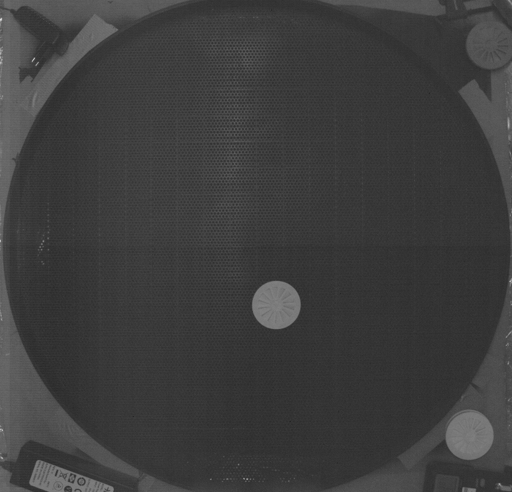

In [6]:
video = pims.Cine('/home/fvega/Datos/brownian_blades/180322/blanca_245.cine')
print('\npixel type is: ', video.pixel_type)
print('\nmovie length is : ', video.len())
print('\nimage resolution is: ', video.frame_shape, ' (X ,Y )\n')
print('\nfirst frame image:\n')
video[0]

In [3]:
np.max(video[0])

445

In [4]:
video.frame_shape
# X is 832 (no. of columns)
# Y is 800 (no. of rows)

(832, 800)

In [5]:
# NOTICE, HOWEVER:
np.shape(video[0])

(800, 832)

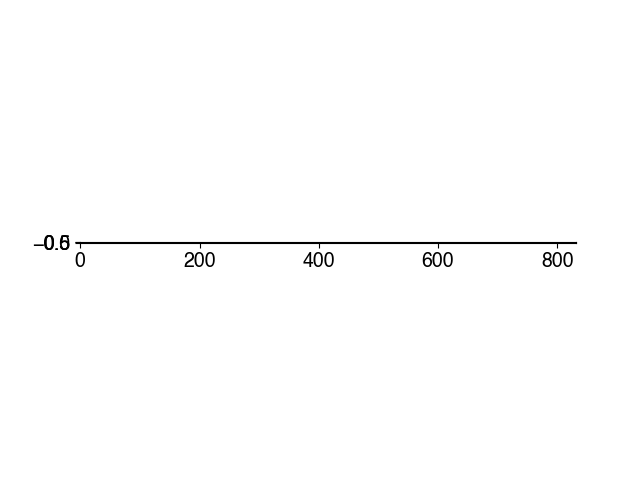

In [7]:
## MATRIX FORMAT: 
## first index is row (Y coord), second index is column (X coord)

# display first row complete (Y value, 1st index)
plt.figure()
plt.imshow(video[0][0:1,:], cmap=cm.binary_r)

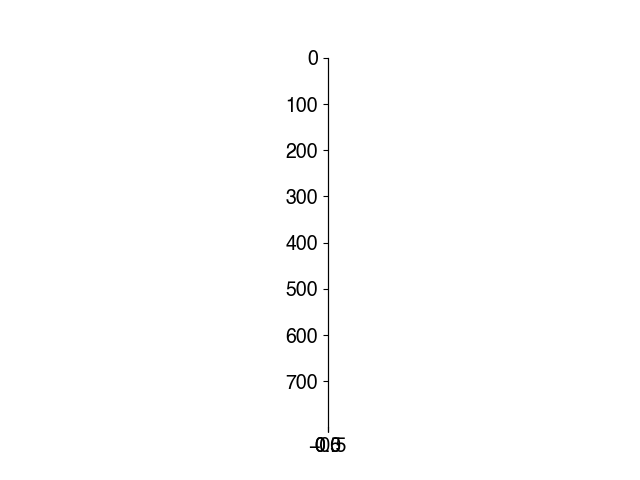

In [8]:
# display first column complete (X value, 2nd index)
plt.figure()
plt.imshow(video[0][:,0:1], cmap=cm.binary_r)
#plt.close()

255


Frame([[222, 225, 221, ..., 192, 194, 198],
       [227, 226, 226, ..., 197, 191, 197],
       [224, 233, 216, ..., 192, 200, 195],
       ...,
       [122, 127, 125, ..., 116, 118, 113],
       [125, 122, 128, ..., 116, 113, 109],
       [126, 125, 130, ..., 118, 122, 122]], dtype=uint8)
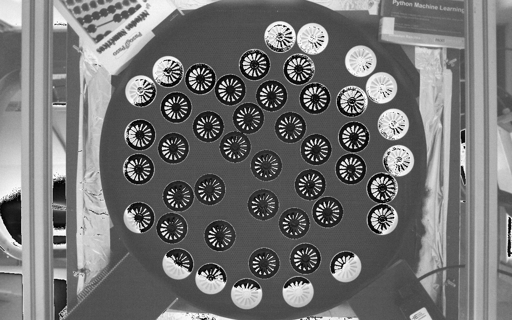

In [3]:
# standar conversion to 8-bit range ([0, 255])
print(np.max(video[0].astype('uint8')))
video[0].astype('uint8')


255


Frame([[222, 225, 221, ..., 192, 194, 198],
       [227, 226, 226, ..., 197, 191, 197],
       [224, 233, 216, ..., 192, 200, 195],
       ...,
       [122, 127, 125, ..., 116, 118, 113],
       [125, 122, 128, ..., 116, 113, 109],
       [126, 125, 130, ..., 118, 122, 122]], dtype=uint8)
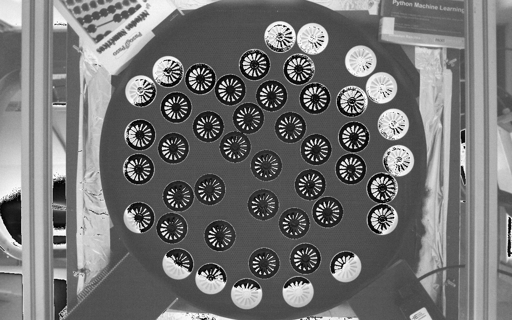

In [4]:
# numpy conversion to 8-bit range ([0, 255])
print(np.max(video[0].astype(np.uint8)))
video[0].astype(np.uint8)


In [5]:
# OpenCV conversion to 8-bit range ([0, 255])
print(np.max(cv.convertScaleAbs(video[0])))
cv.convertScaleAbs(video[0])


255


array([[222, 225, 221, ..., 192, 194, 198],
       [227, 226, 226, ..., 197, 191, 197],
       [224, 233, 216, ..., 192, 200, 195],
       ...,
       [255, 255, 255, ..., 116, 118, 113],
       [255, 255, 255, ..., 116, 113, 109],
       [255, 255, 255, ..., 118, 122, 122]], dtype=uint8)

## <span style="color:red"> *Display Image functions* </span>

### <span style="color:red"> 1- Display frame, OpenCV method (opens separate window) </span>

In [7]:
def cvdisplay(image, tag):
    canvas_name = "frame no. " + str(tag) + ";\tpres 'q' to exit"
    cv.imshow(canvas_name, cv.convertScaleAbs(image))
    cv.waitKey(0)
    cv.destroyAllWindows()


In [8]:
cvdisplay(video[0], 0)

### <span style="color:red"> 2- Display frame, plt.imshow METHOD </span>

In [9]:
def pltdisplay(S, frame, tag):
    canvas_name = 'frame no. ' + str(tag)
    plt.figure(tag,figsize=(S,S))
    plt.title(canvas_name)
    # alternatively convert to 8-bit use opencv function
    plt.imshow(frame, cmap=cm.binary_r)

In [10]:
# bitwise_xor: highlights image differences
imm = cv.bitwise_xor(cv.convertScaleAbs(video[0]), cv.convertScaleAbs(video[2000]))

In [12]:
plt.close('all')

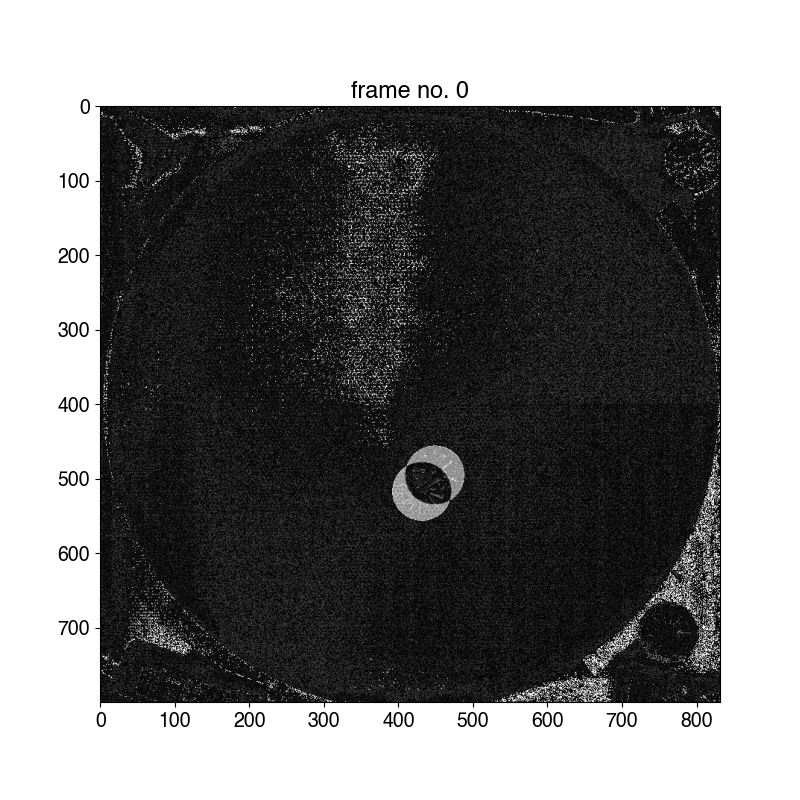

In [11]:
pltdisplay(8, imm, 0)

In [11]:
plt.close('all')

## Examples of pims frames properties

In [10]:
len(video.frame_time_stamps)

38419

In [69]:
video.image_count

24981

In [70]:
video.pixel_type

dtype('uint16')

In [71]:
video.frame_rate_avg

250.00000065586894

In [39]:
video.frame_rate

750

In [18]:
video.frame_time_stamps[:5]

[(datetime.datetime(2022, 3, 18, 11, 57, 54), 0.4923399647232145),
 (datetime.datetime(2022, 3, 18, 11, 57, 54), 0.49367328616790473),
 (datetime.datetime(2022, 3, 18, 11, 57, 54), 0.49500660761259496),
 (datetime.datetime(2022, 3, 18, 11, 57, 54), 0.4963399290572852),
 (datetime.datetime(2022, 3, 18, 11, 57, 54), 0.4976732505019754)]

## <span style="color:red">*Extract exact time stamps of all frames* </span>

* input: video frame (video_obj)
* output: 1D np array (t)

In [13]:
# This function obtains the exact time arrays

def to_time(video_obj):
    
    times = np.array(video_obj.frame_time_stamps).T
    t = np.zeros(video_obj.image_count) 
    s = times[0][0]
    ns = 0
    for i in range(video_obj.image_count):
        if times[0][i].second != s:
            ns = ns + 1
            s = times[0][i].second
        t[i] = times[1][i] + ns

    t = t - times[1][0]
    
    return t

In [16]:
# create frame with one less row than time steps (last one does not have velocity)
datos = pd.DataFrame(index=np.arange(video.image_count), columns=['x', 'y', 'sigma', 't'])

datos.t = to_time(video)
datos.t[:5]

0    1.000000
1    1.001333
2    1.002667
3    1.004000
4    1.005333
Name: t, dtype: float64

In [17]:
# average relative difference between actual average fr rate and nominal fps
100*(1-np.abs((np.mean(np.diff(datos.t)) - video.frame_rate)/video.frame_rate))

0.00017777619046865922

## <span style="color:red">*Circular mask (arbitrary center)* </span>

* input: X image size, Y image size, x circle center pos, y circ center pos, circ radius, image to mask
* output: masked image (centered in image circle)

In [18]:
def black_frame(LX, LY, datatype):
    return np.zeros((LY,LX), dtype=datatype)

black = black_frame(video.frame_shape[0], video.frame_shape[1], np.uint8)
black16 = black_frame(video.frame_shape[0], video.frame_shape[1], np.uint16)

In [19]:
cvdisplay(black,1)

In [20]:
def circle_mask(x0, y0, R, image, base_frame):
    return cv.bitwise_and(image, image, \
    mask = cv.circle(np.copy(base_frame), (round(x0),round(y0)), round(R), 255, -1) ) 
    # np.copy is necessary; otherwise cv.circle modifies base_frame

In [21]:
LX = int(video.frame_shape[0])
LY = int(video.frame_shape[1])
ex0 = 10 # system center eccentricity (X); estimated by hand
ey0 = 0 # idem, for Y # estimated by hand

# center the circle
x0 = int(LX/2) + ex0
y0 = int(LY/2) + ey0
# radius of the mask, approached over the image shortest side
R = int(np.min(np.shape(video[0]))/2)

masked_frame = circle_mask( x0, y0, R, video[0], black)
cvdisplay( masked_frame , 0)

In [22]:
# OPTIONAL: intensity (binary) threshold
ret, masked_th_frame = cv.threshold( masked_frame, 200, 255, cv.THRESH_TOZERO)

In [23]:
cvdisplay( masked_th_frame, 4)

## <span style="color:red">*Draw circle (arbitrary center)* </span>

In [24]:
# for originally gray scale images
def circle_line(x0,y0, R, rc, gc, bc, w, image):
    return cv.circle( np.copy(cv.cvtColor(image, cv.COLOR_GRAY2RGB)), (round(x0),round(y0)), round(R), (bc,gc,rc), w)

In [25]:
# for originally RGB images
def circle_line_rgb(x0,y0, R, rc, gc, bc, w, image):
    return cv.circle( np.copy(image), (round(x0),round(y0)), round(R), (bc,gc,rc), w)

In [26]:
cvdisplay( circle_line(x0,y0,R, 255,0,0, 2, masked_frame), 5)

## <span style="color:red"> *BILATERAL smoothing* </span>

In [28]:
bilateral = cv.bilateralFilter(cv.convertScaleAbs(masked_frame), 10, 75, 75)

In [ ]:
cvdisplay(bilateral, 11)

## <span style="color:red"><u> Initial Hough Circle detection</u></span>

	cv.HoughCircles(image, method, dp, minDist, param1, param2, minRadius, maxRadius)
    
( see: https://docs.opencv.org/3.4/dd/d1a/group__imgproc__feature.html#ga47849c3be0d0406ad3ca45db65a25d2d)


__im__: input image

__dp__: if dp=1 , the accumulator has the same resolution as the input image. If dp=2 , the accumulator has half as big width and height.

__param1__: edge threshold that will be used by the Canny edge detector (applied to a grayscale image). cvCanny(), internally invoked by cvHoughCircles(), accepts two thresholds. The higher (first) threshold is set to param1 (passed as argument into cvHoughCircles()) and the lower (second) threshold is set to half of this value.

__param2__: Is the value for accumulator threshold. This value is used in the accumulator plane that must be reached so that a line is retrieved.

OUTPUT:

__circles__: Array(s) with *[x0, y0, r]*; *(x0, y0)* center position, *r* particle radius

## <span style="color:red"> *DISK LOCATION function, using*  cv.HoughCircles </span>

dp: _Inverse ratio of the accumulator resolution to the image resolution. For example, if dp=1 , the accumulator has the same resolution as the input image. If dp=2 , the accumulator has half as big width and height. For HOUGH_GRADIENT_ALT the recommended value is dp=1.5, unless some small very circles need to be detected._

param1:	_First method-specific parameter. In case of HOUGH_GRADIENT and HOUGH_GRADIENT_ALT, it is the higher threshold of the two passed to the Canny edge detector (the lower one is twice smaller). Note that HOUGH_GRADIENT_ALT uses Scharr algorithm to compute image derivatives, so the threshold value shough normally be higher, such as 300 or normally exposed and contrasty images._

param2:	_Second method-specific parameter. In case of HOUGH_GRADIENT, it is the accumulator threshold for the circle centers at the detection stage. The smaller it is, the more false circles may be detected. Circles, corresponding to the larger accumulator values, will be returned first. In the case of HOUGH_GRADIENT_ALT algorithm, this is the circle "perfectness" measure. The closer it to 1, the better shaped circles algorithm selects. In most cases 0.9 should be fine. If you want get better detection of small circles, you may decrease it to 0.85, 0.8 or even less. But then also try to limit the search range [minRadius, maxRadius] to avoid many false circles._

also:

param1 - _refers to the edge threshold that will be used by the Canny edge detector (applied to a grayscale image). cvCanny() accepts two thresholds and is internally invoked by cvHoughCircles(). Therefore the higher (first) threshold is set to param1 (passed as argument into cvHoughCircles()) and the lower (second) threshold is set to half of this value._

param2- _Is the value for accumulator threshold. This value is used in the accumulator plane that must be reached so that a line is retrieved._

NOTE: as param1 is increased, canny edge is more demanding and less disks are detected. param2 is always smaller than param1

In [115]:
def locate_brownian_disk(image, m_dist, mr, Mr):
    global lengths
    # loop over param1, increasing until less than 2 disks are detected for a (param1, param2=param1/10) set of values
    p1=100
    while len(\
              cv.HoughCircles(cv.convertScaleAbs(masked_frame), cv.HOUGH_GRADIENT, 2.-0.1*0, dsigma, param1=p1, param2=int(p1/10), minRadius=sigma-Delta_sigma, maxRadius=sigma+Delta_sigma)[0]
             )> 1:
        p1 = p1 + 100
    # loop over dp parameter, decreasing its value (the smaller, the more precise, from 2.0 to 1.0; pick 1.7 if disk exist; if not, pick smaller). the smaller, the better
    test = [[] for i in range(11)]
    for i in range(11):
        test[i] = cv.HoughCircles(image, cv.HOUGH_GRADIENT, 2.-0.1*i, minDist=m_dist, param1=p1, param2=int(p1/10), minRadius=mr, maxRadius=Mr)[0]
        #assert (len(test[i]) == 1), f"THERE MUST BE (only) 1 DISK, but there are: {len(test[i])}"
    lengths = np.array([ len(test[i]) for i in range(11)])
    for i in range(8):
        if len(test[7-i])==1:
            disk = test[7-i][0]
            dp = 1.7 - 0.1*i
            break
    return disk, test, dp , p1, int(p1/100)


In [99]:
lengths

[1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [114]:
len(np.where(np.array(lengths)==1)[0])/2

5.0

In [98]:
masked_frame = circle_mask( x0, y0, R, video[2481], black)# tentative particle diameter  (integer)
disk, test, dp, p1, p2 = locate_brownian_disk( cv.convertScaleAbs(masked_frame), dsigma, sigma-Delta_sigma, sigma+Delta_sigma)

In [92]:
test

[array([[443. , 503. ,  38.2]], dtype=float32),
 array([[443.65, 502.55,  39.66],
        [367.65, 204.25,  37.76]], dtype=float32),
 array([[443.69998, 503.09998,  38.26   ]], dtype=float32),
 array([[442.85, 502.35,  40.23]], dtype=float32),
 array([[444. , 503.2,  38.6]], dtype=float32),
 array([[443.25, 501.75,  40.15]], dtype=float32),
 array([[444.5 , 503.3 ,  39.38]], dtype=float32),
 array([[443.94998, 501.15   ,  38.95   ]], dtype=float32),
 array([[444.6    , 503.40002,  38.44   ]], dtype=float32),
 array([[443.85   , 501.05002,  39.42   ]], dtype=float32),
 array([[444.5, 501.5,  39.4]], dtype=float32)]

In [31]:
video.image_count

38419

In [182]:
def get_disk_aura(expand, image, disk, bplot):
    
    ################################################################
    # CREATE AND DISPLAY AURA CONTOURS, for precise location of disk, by integration of disk optical borders

    # preliminary circular mask around located disk (OpenCV), expand% bigger than detected disk
    #expand = 5 # expand 5%
    masked_disk = circle_mask(disk[0], disk[1], disk[2] * (1.+expand /100) , image, black)
    # contours are obtained out of blurred masked disk
    blur_masked_disk = cv.GaussianBlur(cv.medianBlur(masked_disk, 5), (5,5),0)
    #blur_masked_disk = cv.GaussianBlur(masked_disk, (5,5),0)
    

    # we define "AURA" as the disk optical border; i.e., the image region where its brightness decreases from disk image max to grid avg value
    # detect "aura" contours (SciKit) inside the preliminary mask around disk. detection by px brightness (level parameter)
    # inner aura contour, marking inner limit to disk optical boundary (aura) 
    contour_out = scikit.measure.find_contours(blur_masked_disk, fully_connected='high', level=100 ) # contour pixels at 100 value
    if np.shape(contour_out)[0] >1:
        print('outer contour detection failed\n')
    # outer contour, marks outer limit of disk optical boundary (aura); i.e., fading to background
    contour_in = scikit.measure.find_contours(blur_masked_disk, fully_connected='high', level=180 ) # contour pixels at 180 value
    if np.shape(contour_in)[0] >1:
        print('inner contour detection failed\n')

    # plot (matplotlib) detected aura contours
    if bplot == True:
        fig, ax = plt.subplots()
        plt.title('Disk Aura contours')
        ax.imshow(blur_frame, cmap=plt.cm.gray)
        for contour in contour_out:
            ax.plot(contour[:, 1], contour[:, 0], linewidth=2)
        for contour in contour_in:
            ax.plot(contour[:, 1], contour[:, 0], linewidth=2)
    
    return contour_in[0], contour_out[0], masked_disk
    ################################################################

In [126]:
cvdisplay(masked_disk, 14)

In [27]:
def get_masked_disk(contour_in, contour_out, image):
    
    ## OUTER CONTOUR mask, disk mask is now re-adjusted to aura outer limit
    #####################
    disk_mask = np.zeros(image.shape)
    
    # mask is rebuilt by means of SciKit draw.plygon procedure over, this time adjusting to outer contour
    xx, yy = scikit.draw.polygon(contour_out[:, 0], contour_out[:, 1], disk_mask.shape)
    disk_mask[xx, yy] = 255
    disk_mask = disk_mask.astype(np.uint8)
    #cvdisplay(disk_mask, 9)
    
    # create "masked disk" image, using outer contour: everything outside is wiped out, except for disk + aura
    masked_disk = cv.bitwise_and(image, image, mask = disk_mask)
    #cvdisplay(masked_disk,10)
    ################################################################
    
    ####################
    # INNER CONTOUR mask, for aura masking (preserves brightness structure of border, for better disk mass center calc
    ####################
    # (again) create template of disk_shaped mask
    disk_mask = np.zeros(image.shape)  
    # repeat procedure but this time draw inner region to contour_in
    xx, yy = scikit.draw.polygon(contour_in[:, 0], contour_in[:, 1], disk_mask.shape)
    disk_mask[xx, yy] = 255
    disk_mask = disk_mask.astype(np.uint8)
    
    # disk inside disk border  (aura masked out)
    masked_disk_2 = cv.bitwise_and(masked_disk, masked_disk, mask=disk_mask)
    #cvdisplay(masked_disk_2, 11)
    return masked_disk, masked_disk_2
    

In [28]:
def integrate_disk(masked_disk_2, masked_disk):

    # 1 STAGE: preparation of image for averaging
    # pixel average of disk inside disk border: m00/sum of non-black px
    px_avg_disk_2 = cv.moments(masked_disk_2)['m00']/np.sum(cv.threshold(masked_disk_2, 100, 1, cv.THRESH_BINARY)[1])
    px_avg_disk_2 = round(px_avg_disk_2)
    # replace inner full disk pixels with px avg
    masked_disk_2 = cv.threshold(masked_disk_2, 100, px_avg_disk_2, cv.THRESH_BINARY)[1]
    
    ## create inverse disk inner disk mask, with px avg, for selection only the aura
    disk_mask_2 = cv.threshold(masked_disk_2, 0, 255, cv.THRESH_BINARY_INV)[1].astype(np.uint8)
    # isolate and create image of aura (masked_aura)
    masked_aura = cv.bitwise_and(masked_disk, masked_disk, mask=disk_mask_2)
    # add disk aura + averaged inner mask
    disk_for_xy = cv.add(masked_disk_2, masked_aura)
    ##
    
    # 2nd STAGE: averaging of prepared disk image
    # obtain mass center from these 2 images sum. mass center is the improved disk center location
    momentos = cv.moments(disk_for_xy) # save moments of aura + inner avg disk mask
    dx0 = momentos['m10']/momentos['m00'] # mass center, X coordinate
    dy0 = momentos['m01']/momentos['m00'] # mass center, Y coordinate
    #print('( ', dx0,' ', dy0, ') \n')
    return round(dx0,4), round(dy0,4)


## <span style="color:red"> *Full processing function* </span>
(masks disk based on previous disk location)

In [30]:
video.image_count

38419

In [183]:
#######################################################################################################################
########## initial disk detection, by detecting circle (OpenCV, see cell above and below for iteration) ###############
#######################################################################################################################

################################################################
# SETUP CIRCULAR MASK, FOR THE WHOLE MOVIE
LX = int(video.frame_shape[0])
LY = int(video.frame_shape[1])
ex0 = 10 # system center eccentricity (X); estimated by hand
ey0 = 0 # idem, for Y # estimated by hand

# center the circle
x0 = int(LX/2) + ex0
y0 = int(LY/2) + ey0
# radius of the mask, approached over the image shortest side
R = int(np.min(np.shape(video[0]))/2)
################################################################

################################################################
# DEFINE PARTICLE PARAMETERS for Hough Circle Detection
sigma = 40
# % of particle diameter look & find range (integer)
percent_ds = 8 
# diameter interval (integer)
Delta_sigma = int(sigma * 0.01 * percent_ds  )
# expected distance between disks
dsigma = 50
################################################################

dx0, dy0 = np.zeros((2, video.image_count))

for i in range(video.image_count):
    
    ################################################################
    # PRODUCE ORIGINAL INPUT IMAGE 
    # get masked frame from movie frame
    masked_frame = circle_mask( x0, y0, R, video[i], black)# tentative particle diameter  (integer)
    ################################################################  

    
    ################################################################
    # HOUGH CIRCLE IDENTIFICATION, with automated choice set of hough parameters (only needs approx. particle diameter pre-input)
    ##################################   image in gray scale,            disk dist., min. diameter,  max. diameter
    disk, test, dp, p1, p2 = locate_brownian_disk( cv.convertScaleAbs(masked_frame), dsigma, sigma-Delta_sigma, sigma+Delta_sigma)
    ################################################################
    
    
    ################################################################
    # CREATE AND DISPLAY AURA CONTOURS, for precise location of disk, by integration of disk optical borders (previously passed over gauss. blurring)
    #################################
    contour_in, contour_out, masked_disk = get_disk_aura(5, masked_frame, disk, False)
    ################################################################
    
    masked_disk = cv.convertScaleAbs(masked_disk) # from here, we pass to work always with 8-bit (gray scale) image
    
    ################################################################
    # HIGH PRECISION MASKED INNER DISK (masked_disk) AND AURA (masked_disk_2), USING INNER/OUTER CONTOURS
    #####################
    masked_disk, masked_disk_2 = get_masked_disk(contour_in, contour_out, masked_disk)
    ################################################################
    

    ################################################################
    # INTEGRATION OF DISK BRIGHTNESS 
    #####################
    dx0[i], dy0[i] = integrate_disk( masked_disk_2, cv.bilateralFilter(masked_disk, 10, 75, 75) )
    ################################################################
    
    if i%10==0:
        printp(str(i))
    
# draw results, adding system boundary and improved disk center location over masked_disk frame
pointed_disk = circle_line(dx0[0],dy0[0],1, 255,0,0, 1, masked_disk)
cvdisplay( cv.circle( pointed_disk, (x0,y0), R, (0,0,255), 2), 0 )


29460

KeyboardInterrupt: 

In [ ]:
cv.bilateralFilter(masked_disk, 10, 75, 75)

In [155]:
cvdisplay(masked_disk, 16)

In [163]:
contour_in, contour_out, masked_disk = get_disk_aura(5, masked_frame, disk, False)

In [119]:
dx0v1 = dx0.copy()
dy0v1 = dy0.copy()

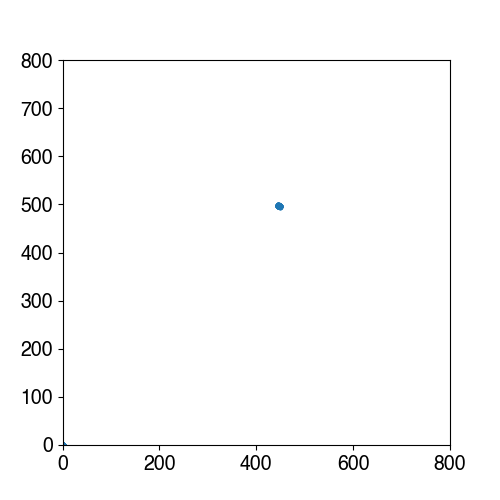

In [181]:
plt.figure(figsize=(5,5))
plt.xlim(0,800)
plt.ylim(0,800)
plt.plot(dx0, dy0,'.')

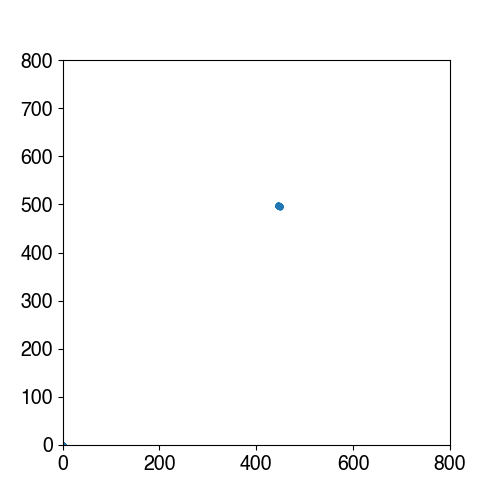

In [175]:
plt.figure(figsize=(5,5))
plt.xlim(0,800)
plt.ylim(0,800)
plt.plot(dx0, dy0,'.')

In [118]:
plt.plot(dx0, dy0,'.')

In [180]:
plt.close('all')

In [47]:
200%100

0

In [49]:
round(dx0, 4)

448.6446

In [53]:
dx0

448.6446

In [62]:
cvdisplay(masked_disk,13)

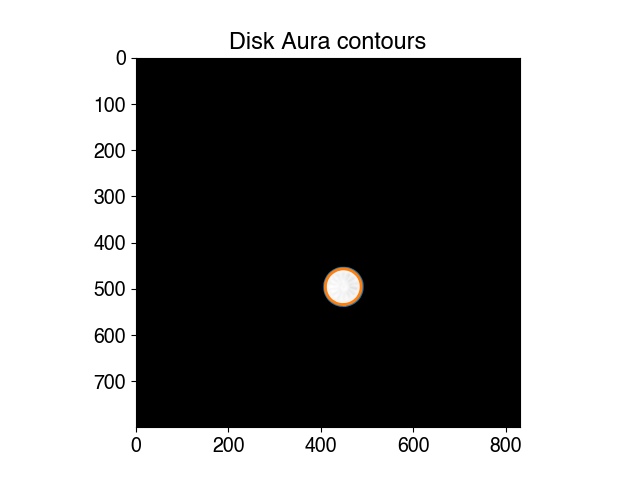

In [37]:
contour_in, contour_out, masked_disk = get_disk_aura(5, masked_frame, disk, True)

In [61]:
masked_disk, masked_disk_2 = get_masked_disk(contour_in, contour_out, masked_disk)

In [54]:
cvdisplay(masked_disk, 12)

In [44]:
integrate_disk(masked_disk_2, masked_disk)

(448.644597838575, 495.5765839396968)

In [19]:
system_transparency = 0.2
composed_frame = cv.addWeighted(masked_frame, system_transparency, masked_disk, 0.8-system_transparency, 0)
#cvdisplay(composed_frame,1)
circled_composed_frame = circle_line( x0, y0, R, 255,0,0,2, cv.convertScaleAbs(composed_frame))
cvdisplay(circled_composed_frame, 2)

In [108]:
circled_composed_frame.dtype

dtype('uint8')

In [28]:
cvdisplay(composed_frame,1)

In [23]:
image = masked_disk
# Rescale image intensity so that we can see dim features.
image = scikit.exposure.rescale_intensity(image, in_range=(120,255), out_range=(0,255))
kernel = np.ones((2, 2), np.uint16)
img_erode = cv.convertScaleAbs(cv.erode(image.astype(np.uint16), kernel, iterations=1))
cvdisplay(img_erode, 0)

In [33]:
img_erode.dtype

dtype('uint8')

In [26]:
_,alpha = cv.threshold(img_erode,0,255,cv.THRESH_BINARY)
rgba = cv.merge([img_erode, img_erode, img_erode, alpha], 4)
crop_rgba = rgba[:,250:1050]
cvdisplay(crop_rgba, 5)

In [29]:
fig4s = cv.imread('/home/fvega/Datos/blades/movies/fig4s.png')
cvdisplay( fig4s, 5)

In [30]:
neg_fig4s = cv.cvtColor( cv.threshold( fig4s, 210, 255, cv.THRESH_BINARY_INV)[1], cv.COLOR_BGR2GRAY)
masked_fig4s= cv.bitwise_and( fig4s,fig4s, mask=neg_fig4s)
cvdisplay( masked_fig4s, 6)

In [59]:
disk[1]

495.94998

In [64]:
round(disk[1],4)

495.95

In [66]:
round(disk[2],4)

39.99

In [28]:
cv.imwrite('/home/fvega/Datos/blades/movies/masked_fig4s.png' ,masked_fig4s)

NameError: name 'masked_fig4s' is not defined

In [103]:
# COMPLEX PHASE CROP

scale = 1/0.79
width = int(masked_fig4s.shape[1] * scale)
height = int(masked_fig4s.shape[0] * scale)
resc = (width, height)
resized_masked_fig4s = cv.resize(masked_fig4s, resc, interpolation = cv.INTER_AREA)
#cvdisplay(resized_masked_fig4s, 2)
crop_masked_fig4s = resized_masked_fig4s[173-40-10:173-40+800-10, 1100-40:1100-40+800]
cvdisplay( crop_masked_fig4s, 9)

In [ ]:
# C_ PHASE CROP
scale = 1/0.825
width = int(masked_fig4s.shape[1] * scale)
height = int(masked_fig4s.shape[0] * scale)
resc = (width, height)
resized_masked_fig4s = cv.resize(masked_fig4s, resc, interpolation = cv.INTER_AREA)
#cvdisplay(resized_masked_fig4s, 2)
crop_masked_fig4s = resized_masked_fig4s[150-40-10:150-40+800-10, 1985-40:1985-40+800]
cvdisplay( crop_masked_fig4s, 9)

In [35]:
crop_masked_frame = masked_frame[:,250:1050]
#cvdisplay(crop_masked_frame, 3)
rgb_crop_masked_frame = cv.cvtColor( cv.convertScaleAbs(crop_masked_frame), cv.COLOR_GRAY2BGR)
cvdisplay(rgb_crop_masked_frame, 8)

In [104]:
composed_im = cv.addWeighted(crop_masked_fig4s,0.9,rgb_crop_masked_frame , 0.3,0)
circled_composed_im =  circle_line_rgb(400,400,400,0,175,175,4, composed_im)
r, g , b = cv.split(circled_composed_im)
alpha2 = 255* np.ones((800,800)).astype('uint8')
alpha_composed_im = cv.merge([r,g,b,alpha2])
total_im = cv.addWeighted(crop_rgba , 0.7, alpha_composed_im, 1, 0)
cvdisplay(total_im, 7)

In [105]:
cv.imwrite('/home/fvega/Datos/blades/movies/test_v4_1.png', total_im)

True

In [138]:
pwd

'/home/fvega/Codigos/brownian'

In [37]:
lista_experimentos = read_ods('/home/fvega/Datos/blades/tabla_experimentos.ods', sheet=0)


In [50]:
lphi45 = lista_experimentos[lista_experimentos.phi==0.45]

In [52]:
lphi45

,ID,N,P,phi,fps,Tt,w,w_std,u_air,sigma,ROI_center,ROI_radius,serie,Tt_900fps,w_900fps,unnamed.1
61,5ac8543758342346a52402e578bfaf41,45.0,20.0,0.45,250.0,0.455877,-0.387854,0.346244,2.3151,78.0,"[656, 395]",408.0,nivelado1,NaN,NaN,None
62,9bd37c11859b49f916d355e03d62a6fc,45.0,20.0,0.45,900.0,0.455877,-0.387854,0.496392,2.3151,78.0,"[656, 395]",408.0,nivelado1,8.824612,-0.413369,None
63,155e9e3bf635544e8ff7240c760bee7b,45.0,20.8,0.45,250.0,0.627246,-0.245044,0.282056,2.3924,74.0,"[662, 383]",381.0,relleno_mapa_fases2,NaN,NaN,None
64,0aa7ece214139db8501bb5b4ac3fbdc1,45.0,21.0,0.45,250.0,0.706609,-0.150861,0.259200,2.4117,74.0,"[662, 383]",381.0,relleno_mapa_fases4,NaN,NaN,None
65,48d0a742c060c9b28e30e8b2490c80bc,45.0,21.3,0.45,250.0,0.803102,-0.107098,0.256426,2.4407,74.0,"[662, 383]",381.0,relleno_mapa_fases4,NaN,NaN,None
66,9cd14eb3963525cea5f0ea8e5ad33614,45.0,21.5,0.45,250.0,1.087504,0.012065,0.254769,2.4600,74.0,"[662, 383]",381.0,relleno_mapa_fases,NaN,NaN,None
67,f509f3b902a7ada8064a9247404d7019,45.0,21.7,0.45,250.0,1.160905,0.055883,0.293315,2.4793,74.0,"[662, 383]",381.0,relleno_mapa_fases4,NaN,NaN,None
68,d55cb1546d02979fa61786c347dd440d,45.0,22.0,0.45,250.0,1.499319,0.145326,0.311617,2.5083,74.0,"[662, 383]",381.0,relleno_mapa_fases2,NaN,NaN,None
69,fa20f7895bd20257d9a2531abe98bf8e,45.0,22.0,0.45,250.0,1.692696,0.162205,0.341537,2.5083,78.0,"[656, 395]",408.0,nivelado0,NaN,NaN,VERSIÓN DE 900FPS NO DISPONIBLE
70,656ac3f84a53672294b835362a2c563f,45.0,22.0,0.45,250.0,1.775451,0.221584,0.347465,2.5083,78.0,"[656, 395]",408.0,nivelado1,NaN,NaN,None


In [49]:
lista_experimentos[(lista_experimentos.w > 0.25) & (lista_experimentos.w < 0.27)]

,ID,N,P,phi,fps,Tt,w,w_std,u_air,sigma,ROI_center,ROI_radius,serie,Tt_900fps,w_900fps,unnamed.1
34,44b967a39c4386471bfbda8d7a2af411,10.0,28.0,0.1,250.0,3.459757,0.263015,1.286315,3.0879,78.0,"[656, 395]",408.0,nivelado0,NaN,NaN,None
35,25bf2a638b2cb96ec6bf4b38b0314341,10.0,28.0,0.1,900.0,3.459757,0.263015,2.348602,3.0879,78.0,"[656, 395]",408.0,nivelado0,3.014863,0.024579,None


[357.69998  478.1       44.120003]


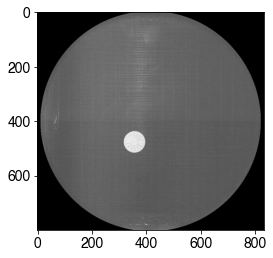

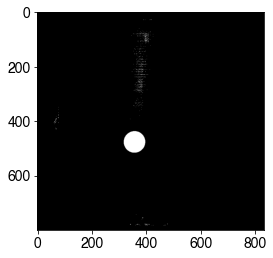

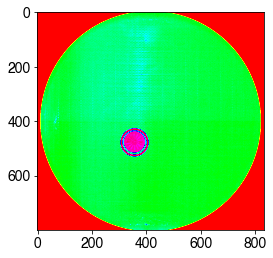

In [131]:
Rfact = 1.01 # factor of increase/decrease system radius
R =  0.5* np.min(np.shape(video[0])) # circular boundary radius, assuming image is adjusted to boundary

masked_image, image = circ_mask(cv.convertScaleAbs(video[0]), R, Rfact)

plt.figure()
plt.imshow(masked_image, cmap=cm.binary_r)

circles = None
dp = 1
tR = 45
dfact=2
cs = 2

# Iteratively search for disks, self-adjusting parameters to best fit
while cs>1:
    while circles is None and dp<tR:
        circles = locate_disk(masked_image, dp, dfact*tR, int(tR/2), tR)
        dp = dp + 0.1
    cs = np.shape(circles[0])[0]
    if cs>1: 
        dfact = dfact * 0.95
circles = circles[0,0]

print(circles)

inrange_image = cv.inRange(masked_image, 150, 255)

# Thresholding
plt.figure()
plt.imshow(inrange_image, cmap=cm.binary_r)

x0 = int(circles[0])
y0 = int(circles[1])
r = int(circles[2])

cir_image = np.copy(masked_image)
cv.circle(cir_image, (int(circles[0]),int(circles[1])), int(1.1*r), (255,255,0), 5);
plt.figure()
plt.imshow(cir_image,cmap=cm.hsv)



In [68]:
locate_disk(cv.inRange(imm, 150,255), 3.1, 100, 30, 45)

array([[[354.94998, 475.84998,  40.23   ]]], dtype=float32)

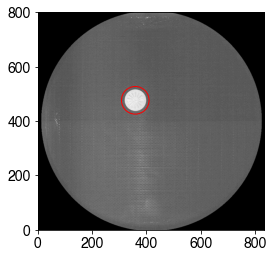

In [32]:

figure, axes = plt.subplots() 

cc = plt.Circle((circles[0], circles[1]), circles[2], edgecolor='r'
                ,facecolor='none' )
plt.xlim(0,832)
plt.ylim(0,800)
axes.add_artist(cc)
plt.imshow(masked_image, cmap=cm.binary_r)


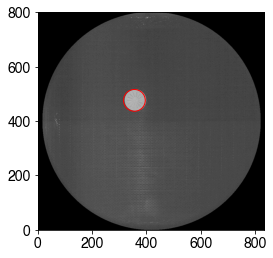

In [400]:
circles = cv.HoughCircles(image, cv.HOUGH_GRADIENT, 1.5, 50
                          ,minRadius=30,maxRadius=50)

figure, axes = plt.subplots() 
cc = plt.Circle((circles[0,0,0], circles[0,0,1]), circles[0,0,2], edgecolor='r'
                ,facecolor='none' )
plt.xlim(0,832)
plt.ylim(0,800)
axes.add_artist(cc)
plt.imshow(masked_image, cmap=cm.binary_r)


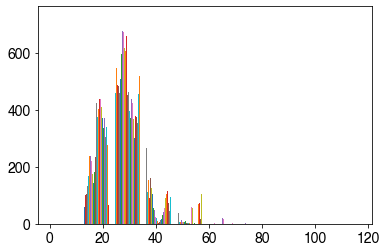

In [102]:
plt.hist(frame.T[0]);

In [142]:
ret, binary_ad = cv.threshold(image,40,255,cv.THRESH_BINARY+cv.THRESH_OTSU)

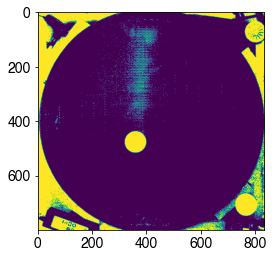

In [143]:
plt.figure()
plt.imshow(binary_ad)

TypeError: 'NoneType' object is not subscriptable

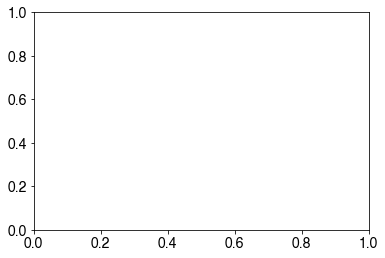

In [144]:
circles = cv.HoughCircles(binary_ad, cv.HOUGH_GRADIENT, 1,1
                          ,minRadius=10,maxRadius=90)

figure, axes = plt.subplots() 
cc = plt.Circle((circles[0,0,0], circles[0,0,1]), circles[0,0,2], edgecolor='r'
                ,facecolor='none' )
plt.xlim(0,800)
plt.ylim(0,832)
axes.set_aspect(1)
axes.add_artist(cc)
plt.imshow(image)

In [184]:
region = np.zeros((np.shape(image)[0], np.shape(image)[1]), dtype=np.uint8)
mask = cv.circle(region, (400,416), 410, 255, -1)

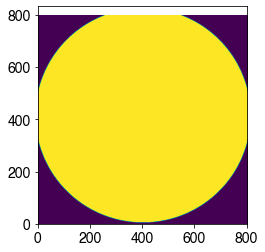

In [185]:
plt.figure()
plt.xlim(0,800)
plt.ylim(0,832)
plt.imshow(mask)



In [169]:
np.shape(image)

(800, 832)

In [159]:
cv.HoughCircles(image, cv.HOUGH_GRADIENT, 2, 300
                          ,minRadius=1, maxRadius=500)

array([[[763. , 709. ,  38. ],
        [355. , 475. ,  41.2]]], dtype=float32)

In [159]:
cv.HoughCircles(image, cv.HOUGH_GRADIENT, 2, 300
                          ,minRadius=1, maxRadius=500)

array([[[763. , 709. ,  38. ],
        [355. , 475. ,  41.2]]], dtype=float32)

In [68]:
np.shape(image)

(800, 832)

In [75]:
circles[0,0,1]

476.25

In [43]:
circles = cv.HoughCircles(image, cv.HOUGH_GRADIENT, 1.5,1
                          ,minRadius=1,maxRadius=90)

In [56]:
circles[0,0,0]

356.25

In [57]:
for i in icircles[0,:]:
    # draw the outer circle
    cv.circle(frame.T[0],(i[0],i[1]),i[2],(0,255,0),2)

error: OpenCV(4.5.3) :-1: error: (-5:Bad argument) in function 'circle'
> Overload resolution failed:
>  - Layout of the output array img is incompatible with cv::Mat (step[ndims-1] != elemsize or step[1] != elemsize*nchannels)
>  - Expected Ptr<cv::UMat> for argument 'img'


In [ ]:
cv2.waitKey(0) 

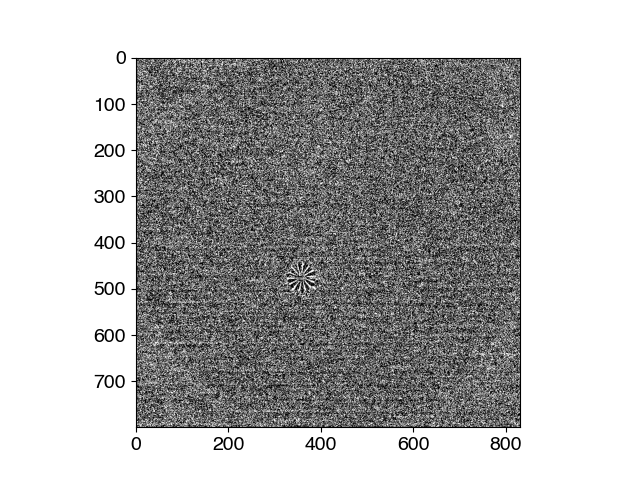

In [14]:
plt.figure(1)
plt.imshow(video[1]-video[0])

In [5]:
datos = pd.read_pickle('tracks/3988fa72e13c390c35b4a55c0495bc63.pkl.xz')
datos = datos[['x','y','frame']]

X = datos.x.values
Y = datos.y.values
it = datos.frame.values
xf = signal.savgol_filter(X, 9, 5)
yf = signal.savgol_filter(Y, 9, 5)
vxf = xf[1:] - xf[:-1]
vyf = yf[1:] - yf[:-1]
xf = xf[:-1]
yf = yf[:-1]

nframes = len(datos)-1

datos.head()


,x,y,frame
0,363.396279,533.013782,1
1,363.571671,533.130123,2
2,363.886110,533.025815,3
3,363.869190,533.091061,4
4,363.420557,533.088331,5


In [6]:
def update(dt):
    plt.close('all')
    fig = plt.figure(figsize=(7.5,6))
    cmm = colors.ListedColormap.reversed(cm.viridis)
    ecolors = (cm.viridis_r((it[::dt]/ it[::dt].max()) ))
    dr = np.max([xf.max()-xf.min(), yf.max()-yf.min()]) *1.1
    plt.xlim(xf.min()*0.9,xf.min()+dr)
    plt.ylim(yf.min()*0.9,yf.min()+dr)
    plt.scatter(xf[::dt], yf[::dt], s=80, facecolors='none', edgecolors=ecolors, linewidths=0.75, alpha=0.75)
    normc = norm = colors.Normalize(vmin=0, vmax=100)
    cbar=plt.colorbar(cm.ScalarMappable(cmap=cm.viridis_r, norm = normc),
                      label= 'time (% of movie length)',orientation="vertical",shrink=0.99)
    #fig.canvas.draw() # with inline
    #fig.show() # with ipympl
    #return fig

In [7]:
plt.close('all')
fig = widgets.interact(update,dt=widgets.BoundedIntText(min=1, max=500, step=1, value=50));

interactive(children=(BoundedIntText(value=50, description='dt', max=500, min=1), Output()), _dom_classes=('wi…

In [9]:
datos.to_csv('tabla.csv')

In [44]:
histx, edgesx = np.histogram(vxf, bins=100, density=True)
histy, edgesy = np.histogram(vyf, bins=100, density=True)
hist, edges = np.histogram(np.sqrt(vxf**2+vyf**2), bins =200, range= (0,1.2),density=True)

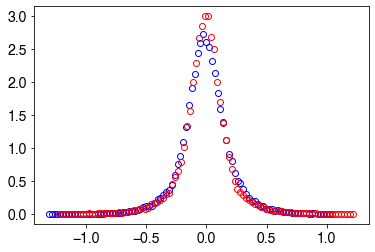

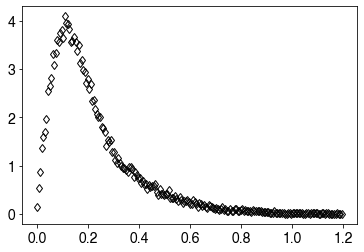

In [47]:
plt.close('all')
plt.figure(2)
plt.plot( edgesx[:-1], histx,'o',mfc='none', mec='b');
plt.plot(edgesy[:-1], histy, 'o', mfc='none',mec='r');
plt.figure(3)
plt.plot(edges[:-1], hist, 'd',c='k',mfc='none');